In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [2]:
reward_list = []
for i in range(1, 9):
    file_path = f'E:/SS_data/model/epoch{i}/r_list.pkl'
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        reward_list.extend(data)
reward = [x.item() for x in reward_list]

In [3]:
loss_list = []
for i in range(1, 9):
    file_path = f'E:/SS_data/model/epoch{i}/l_list.pkl'
    with open(file_path, 'rb') as file:
        data = pickle.load(file)
        loss_list.extend(data)
loss = [x.item() for x in loss_list]

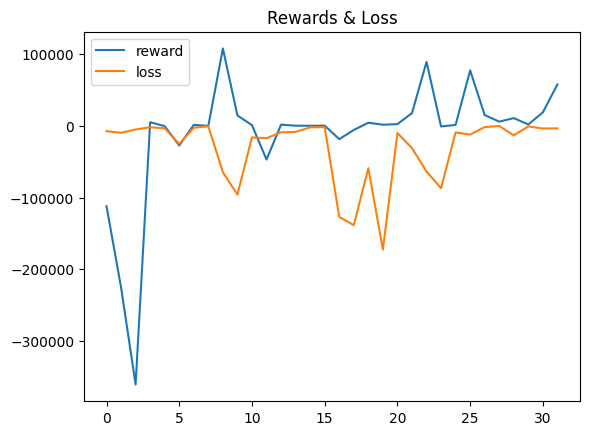

In [6]:
plt.plot(reward, label='reward')
plt.plot(loss, label='loss')
plt.title("Rewards & Loss")
plt.legend()
plt.show()

In [1]:
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as Data
import torch
from d2l import torch as d2l
from torch import nn
import torch.optim as optim
import math
from torch.nn import functional as F
from torch.distributions import Categorical
import gym
from gym import spaces

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]  
def load(dataset, batch_size):
    loader = Data.DataLoader(dataset=dataset,
                         batch_size=batch_size,
                         shuffle=True)
    return loader

In [7]:
test = torch.load(f'E:/SS_data/dataset/test/testdataset0')
len(test)

128

In [8]:
test_iter = load(test, 128)
for i in test_iter:
    print(i.shape)

torch.Size([128, 2457, 54])


In [9]:
devices = d2l.try_all_gpus()
devices

[device(type='cuda', index=0)]

In [10]:
class TACModel(nn.Module):
    def __init__(self, num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout,
                 key_size, query_size, value_size,
                 t_in_features, hid_in_features):
        super(TACModel, self).__init__()
        self.acount = AcountExtract()
        self.encoder = TACEncoder(num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout,
                 key_size, query_size, value_size)    
        self.tap = TransiActionPred(t_in_features)
        self.tnp = TransiNumberPred(t_in_features)
        self.value = ValueNet(t_in_features)
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens),
                                    nn.Tanh())

    def forward(self, x, acount):
        Acount  = self.acount(acount)
        X = torch.cat((x,Acount), dim=2)
        encoded_X = self.encoder(X)
        action_hat = self.tap(self.hidden(encoded_X[:, :, -1]))
        number_hat = self.tnp(self.hidden(encoded_X[:, :, -1]))
        value = self.value(self.hidden(encoded_X[:, :, -1]))
        return  action_hat, number_hat, value
    
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        output = self.attention(queries, keys, values)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
    
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.BatchNorm1d(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
    
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X):
        Y = self.addnorm1(X, self.attention(X, X, X))
        return self.addnorm2(Y, self.ffn(Y))
class TACEncoder(nn.Module):
    def __init__(self,num_hiddens, norm_shape, 
                 ffn_num_input,ffn_num_hiddens, num_heads, num_layers, dropout,
                 key_size, query_size, value_size,
                 **kwargs):
        super(TACEncoder, self).__init__(**kwargs)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(torch.randn(1, 56, num_hiddens))

    def forward(self, X):
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X)
        return X
    
class TransiActionPred(nn.Module):
    def __init__(self, num_inputs, **kwargs):
        super(TransiActionPred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 3)
    def forward(self, X):
        return F.softmax(self.output(X), dim=-1)

class TransiNumberPred(nn.Module):       #---使用类别优化器，将交易数量拟合为仓位百分比[10%, 50%. 100%]
    def __init__(self, num_inputs, **kwargs):
        super(TransiNumberPred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 3)
    def forward(self, X):
        return F.softmax(self.output(X), dim=-1)
    
class ValueNet(nn.Module):
    def __init__(self, num_inputs, **kwargs):
        super(ValueNet, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 1)
    def forward(self, X):
        return self.output(X)

class AcountExtract(nn.Module):
    def __init__(self, **kwargs):
        super(AcountExtract, self).__init__(**kwargs)
        self.expand = nn.Linear(2, 56*2)
    def forward(self, X):
        X = X.view(-1, 1, 2)
        X = self.expand(X)
        X = X.view(-1, 56, 2)
        return X
#注意：action和number的多任务分类预测损失函数需改为，两个单独任务的loss加权和，其中权重是超参数

In [11]:
class StockTradingEnv:
    def __init__(self):
        #初始化参数
        self.current_day = 0
        self.state_size = (128, 56, 54)
        self.position_options = torch.tensor([0.1, 0.5, 1.0])
        self.num_stocks = 128

        #初始化状态
        self.account_balance = torch.full((self.num_stocks,), 10000.0)
        self.stock_quantity = torch.zeros(self.num_stocks)
        
        #定义空间
        self.action_space = spaces.Tuple((spaces.Discrete(3), spaces.Discrete(3)))  # 交易行为和交易数量
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, 
                                            shape=self.state_size, dtype=np.float32)

    def load_data(self, data):
        if hasattr(self, 'data'):
            del self.data
        self.data = data
        self.total_days = data.shape[1]   #2457天
        self.reset()

    def reset(self):
        #重置环境状态
        self.current_day = 0
        self.account_balance.fill_(10000.0)
        self.stock_quantity.zero_()

    def step(self, trade_actions, position_actions):
        #获取当前状态
        current_state = self._get_current_state()
        #获取当前股价
        closing_prices = current_state[:,-1,0]
        #计算交易
        rewards = torch.zeros(self.num_stocks)
        for i in range(self.num_stocks):
            closing_price = closing_prices[i]
            trade_action = trade_actions[i]
            position_action = position_actions[i]
            if trade_action == 1:  # 买入
                buy_quantity = (self.account_balance[i] * self.position_options[position_action] / closing_price).floor()
                if buy_quantity > 0:
                    self.account_balance[i] -= buy_quantity * closing_price
                    self.stock_quantity[i] += buy_quantity
                    income = (self.account_balance[i]+self.stock_quantity[i]*closing_price - 10000)/10000
                    rewards[i] = income + 0.1
            elif trade_action == 2:  # 卖出
                sell_quantity = (self.position_options[position_action] * self.stock_quantity[i]).floor()
                if sell_quantity > 0:
                    self.account_balance[i] += sell_quantity * closing_price
                    self.stock_quantity[i] -= sell_quantity
                    income = (self.account_balance[i]+self.stock_quantity[i]*closing_price - 10000)/10000
                    rewards[i] = income 
            else:  # 不交易
                income = (self.account_balance[i]+self.stock_quantity[i]*closing_price - 10000)/10000
                rewards[i] = income
        # 更新当前交易日
        self.current_day += 1
        # 检查是否达到游戏结束
        done = self.current_day >= self.total_days - self.state_size[1] - 1
        next_state = self._get_next_state()
        
        return next_state, rewards, done, _
    
    def _get_current_state(self):
        return self.data[:, self.current_day:(self.current_day + self.state_size[1]), :]
    
    def _get_next_state(self):
        start = self.current_day
        end = start + self.state_size[1]
        return self.data[:, start:end, :]
    
    def get_acount(self):
        # 返回当前状态
        return torch.stack([self.account_balance, self.stock_quantity], dim=1)

In [12]:
class DataMemory:
    def __init__(self):
        self.data = {
            'action': [],
            'number': [],
            'reward': []  }

    def add_data(self, action, number, reward):
        self.data['action'].append(action)
        self.data['number'].append(number)
        self.data['reward'].append(reward)

    def reset(self):
        for key in self.data.keys():
            self.data[key].clear()

    def get_data(self, key):
        return torch.stack(self.data[key])

In [13]:
net = TACModel(num_hiddens=56, norm_shape=[56], 
                 ffn_num_input=56, ffn_num_hiddens=128, num_heads=8, num_layers=12, dropout=0.01,
                 key_size=56, query_size=56, value_size=56, hid_in_features=56, t_in_features=56).to(devices[0]).eval()
pretrained_dict = torch.load("E:/SS_data/model/epoch1/Transformer.params")
net.load_state_dict(pretrained_dict)
datamemory = DataMemory()
env = StockTradingEnv()
env.reset()

In [14]:
for i, state in enumerate(test_iter):
    #创建环境
    env.load_data(state)
    env.reset()
    done = False
    while not done:
        #获得当前环境账户信息
        current_acount = (env.get_acount()).to(devices[0]).float()
        #获得当前状态空间
        current_state = env._get_current_state().float().to(devices[0])
            
        #进入GPU的net，获得动作空间,value
        action_prob, number_prob, _ = net(current_state, current_acount)
        #根据最大概率选择动作
        action_dist = Categorical(action_prob)          
        number_dist = Categorical(number_prob)          
        actions = action_dist.sample().detach()                 
        numbers = number_dist.sample().detach() 
        #进入CPU的环境交互
        next_state, reward, done,_ = env.step(actions.cpu(), numbers.cpu())
        reward = reward.detach()  
        datamemory.add_data(actions, numbers, reward)    
        state = next_state
        if done:
            break

In [19]:
action = datamemory.get_data('action')
action

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [1]:
import numpy as np
import torch

In [2]:
r = torch.load('C:/Users/Administrator/reward')
r_list = torch.stack([r[:,i] for i in range(128)])

In [3]:
r_list[0]

tensor([ 0.1000, -0.0015,  0.1011,  ..., -0.0185, -0.1257, -0.1306])

In [52]:
def calculate_metrics(returns_data, risk_free_rate=0.02):
    results = np.zeros((returns_data.shape[0], 3))
    for i in range(returns_data.shape[0]):
        cumulative_returns = np.cumprod(1 + returns_data[i]) - 1
        total_return = returns_data[i].mean()
        volatility = np.std(returns_data[i])
        sharpe_ratio = (np.mean(returns_data[i]) - risk_free_rate) / volatility
        results[i] = [total_return, volatility, sharpe_ratio]
    return results

In [53]:
metric = np.nan_to_num(calculate_metrics(np.array(r_list)))

In [54]:
metric

array([[-0.18564917,  0.10496169, -1.95927833],
       [ 0.03523499,  0.15358901,  0.09919324],
       [ 0.04109965,  0.10344534,  0.20396911],
       [ 0.47925213,  0.30270591,  1.51715612],
       [-0.19148682,  0.11430734, -1.85015964],
       [ 0.24272333,  0.29730991,  0.74912853],
       [ 0.02504967,  0.12933198,  0.03904423],
       [-0.13789803,  0.10958553, -1.44086565],
       [-0.09923434,  0.19566575, -0.6093777 ],
       [ 0.0411346 ,  0.08015945,  0.26365695],
       [-0.12461164,  0.11182318, -1.29321702],
       [ 0.05898509,  0.15142736,  0.25745076],
       [ 0.31239453,  0.24586216,  1.18926204],
       [-0.08450986,  0.12551269, -0.83266367],
       [ 0.01729307,  0.09996555, -0.02707865],
       [-0.15738441,  0.10080231, -1.75972565],
       [-0.07429247,  0.08070018, -1.16842942],
       [-0.16582735,  0.30125833, -0.61683722],
       [ 0.03961908,  0.13949475,  0.14064387],
       [ 0.32381734,  0.41521806,  0.73170552],
       [-0.30154419,  0.20399372, -1.576

In [55]:
np.mean(metric,axis=0)

array([ 0.04299849,  0.17871744, -0.19072152])